In [4]:

df = pd.read_csv('AMZN.csv')

In [3]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [ ]:
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,49.813290,51.835709,47.800831,49.982655,49.982655,44871361
1,2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942874
2,2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342897
3,2004-08-24,55.412300,55.591629,51.591621,52.239197,52.239197,15319808
4,2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232276


In [5]:
df = df[['Date', 'Close']]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6068 entries, 0 to 6067
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    6068 non-null   object 
 1   Close   6068 non-null   float64
dtypes: float64(1), object(1)
memory usage: 94.9+ KB


In [7]:
df['Date'].min(), df['Date'].max()

('1997-05-15', '2021-06-24')

In [9]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Amazon Inc. Stock Price 2004-2020')
fig.show()

In [10]:
train = df.loc[df['Date'] <= '2017-12-24']
test = df.loc[df['Date'] > '2017-12-24']
train.shape, test.shape

((5188, 2), (880, 2))

In [11]:
scaler = StandardScaler()
scaler = scaler.fit(np.array(train['Close']).reshape(-1,1))

train['Close'] = scaler.transform(np.array(train['Close']).reshape(-1,1))
test['Close'] = scaler.transform(np.array(test['Close']).reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



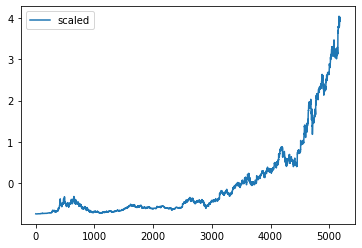

In [12]:
plt.plot(train['Close'], label = 'scaled')
plt.legend()
plt.show()

In [13]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []
    for i in range(len(X)-time_steps):
        X_out.append(X.iloc[i:(i+time_steps)].values)
        y_out.append(y.iloc[i+time_steps])
    
    return np.array(X_out), np.array(y_out)

X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test = create_sequences(test[['Close']], test['Close'])
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (5158, 30, 1)
Testing input shape:  (850, 30, 1)


In [14]:
X_train[3331]

array([[-0.24504521],
       [-0.2423618 ],
       [-0.24985132],
       [-0.24432429],
       [-0.23315005],
       [-0.22998604],
       [-0.23831663],
       [-0.23755566],
       [-0.24220159],
       [-0.25049215],
       [-0.24120032],
       [-0.24917046],
       [-0.24204138],
       [-0.25345592],
       [-0.24929061],
       [-0.21861151],
       [-0.20771762],
       [-0.19337941],
       [-0.19966739],
       [-0.1919776 ],
       [-0.18701125],
       [-0.17876075],
       [-0.16822731],
       [-0.16550387],
       [-0.16670541],
       [-0.1559717 ],
       [-0.15521073],
       [-0.14327554],
       [-0.14555847],
       [-0.14115284]])

In [15]:
np.random.seed(21)
tf.random.set_seed(21)


In [17]:
model = Sequential()
model.add(LSTM(128, activation = 'tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, activation = 'tanh', return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

In [18]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')],
                    shuffle=False)

Epoch 1/100
146/146 [==============================] - 15s 79ms/step - loss: 0.0219 - val_loss: 0.3255
Epoch 2/100
146/146 [==============================] - 11s 73ms/step - loss: 0.0151 - val_loss: 0.2693
Epoch 3/100
146/146 [==============================] - 11s 73ms/step - loss: 0.0076 - val_loss: 0.4165
Epoch 4/100
146/146 [==============================] - 11s 73ms/step - loss: 0.0073 - val_loss: 0.4606
Epoch 5/100
146/146 [==============================] - 11s 74ms/step - loss: 0.0126 - val_loss: 0.0350
Epoch 6/100
146/146 [==============================] - 11s 73ms/step - loss: 0.0088 - val_loss: 0.0270
Epoch 7/100
146/146 [==============================] - 11s 72ms/step - loss: 0.0049 - val_loss: 0.0348
Epoch 8/100
146/146 [==============================] - 11s 73ms/step - loss: 0.0047 - val_loss: 0.0698
Epoch 9/100
146/146 [==============================] - 11s 73ms/step - loss: 0.0038 - val_loss: 0.0519
Epoch 10/100
146/146 [==============================] - 11s 73ms/step - l

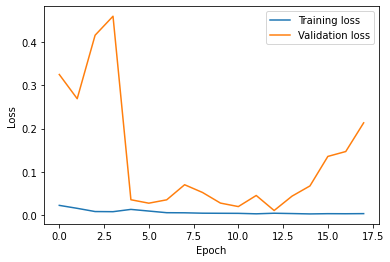

In [19]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

Reconstruction error threshold: 1.0820623731839418


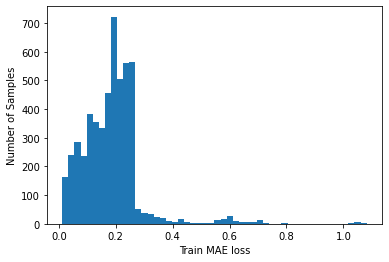

In [20]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)

print('Reconstruction error threshold:',threshold)

27/27 [==============================] - 1s 22ms/step


Text(0, 0.5, 'Number of samples')

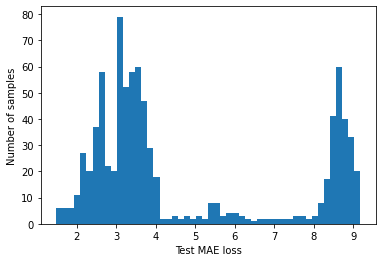

In [21]:

X_test_pred = model.predict(X_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [22]:
anomaly_df = pd.DataFrame(test[TIME_STEPS:])
anomaly_df['loss'] = test_mae_loss
anomaly_df['threshold'] = threshold
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']

In [23]:
anomaly_df.head()

,Date,Close,loss,threshold,anomaly
5218,2018-02-08,4.659643,1.481839,1.082062,True
5219,2018-02-09,4.615988,1.526193,1.082062,True
5220,2018-02-12,4.802746,1.566955,1.082062,True
5221,2018-02-13,4.916010,1.592378,1.082062,True
5222,2018-02-14,5.062357,1.613859,1.082062,True


In [25]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies.head()

,Date,Close,loss,threshold,anomaly
5218,2018-02-08,4.659643,1.481839,1.082062,True
5219,2018-02-09,4.615988,1.526193,1.082062,True
5220,2018-02-12,4.802746,1.566955,1.082062,True
5221,2018-02-13,4.916010,1.592378,1.082062,True
5222,2018-02-14,5.062357,1.613859,1.082062,True


In [26]:
anomalies.shape

(850, 5)

In [27]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=scaler.inverse_transform(anomaly_df['Close']), name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close']), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()